In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os, io, warnings
from ipywidgets import widgets
#from IPython.display import display, Image as im

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
warnings.filterwarnings("ignore")

<div style="background-color:#D3D3D3"><h1><b><center>White-box Cartoon Representations</center></b></h1></div><br>
This is a demo application for the AIDI 1003 Capstone project. <br>
Below are a few examples of images converted into cartoon.

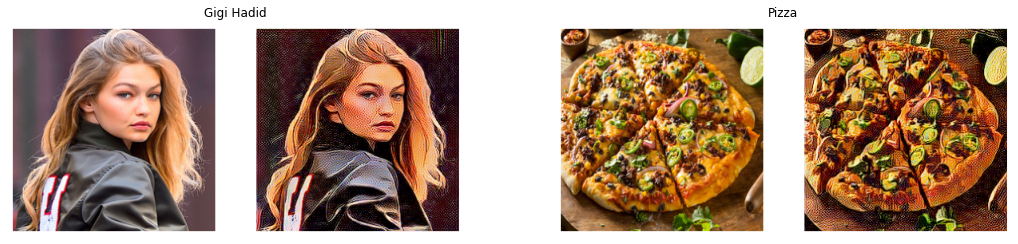

In [66]:
fig, ax = plt.subplots(1,2, figsize=(18, 18))

gigi = np.array(Image.open('./Images/gigi-cartoon.png'))
pizza = np.array(Image.open('./Images/pizza-cartoon.png'))


ax[0].imshow(gigi)
ax[1].imshow(pizza)

ax[0].axis('off')
ax[0].set_title("Gigi Hadid")
ax[1].axis('off')
ax[1].set_title("Pizza")


plt.show()

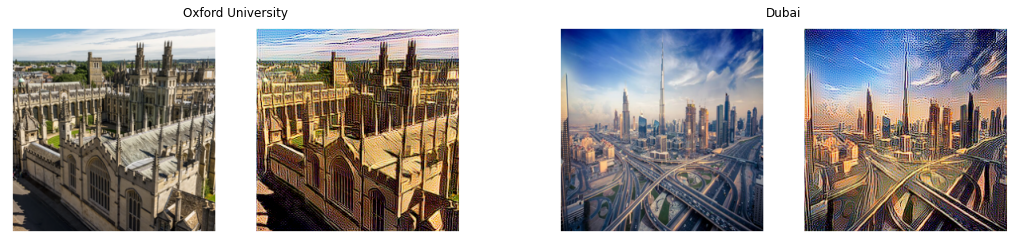

In [67]:
fig, ax = plt.subplots(1,2, figsize=(18, 18))

oxford = np.array(Image.open('./Images/oxford-cartoon.png'))
dubai = np.array(Image.open('./Images/dubai-cartoon.png'))

ax[0].imshow(oxford)
ax[1].imshow(dubai)

ax[0].axis('off')
ax[0].set_title("Oxford University")
ax[1].axis('off')
ax[1].set_title("Dubai")

plt.show()

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size, stride, padding, padding_mode):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode=padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode=padding_mode),
        )

    def forward(self, x):
        #Elementwise Sum (ES)
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=32, num_residuals=4):
        super().__init__()
        self.padding_mode = "zeros"

        self.initial_down = nn.Sequential(
            #k7n32s1
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

        #Down-convolution
        self.down1 = nn.Sequential(
            #k3n32s2   256, 256, 32
            nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #k3n64s1   128, 128, 64
            nn.Conv2d(num_features, num_features*2, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

        self.down2 = nn.Sequential(
            #k3n64s2
            nn.Conv2d(num_features*2, num_features*2, kernel_size=3, stride=2, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #k3n128s1  64, 64, 128
            nn.Conv2d(num_features*2, num_features*4, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

        #Bottleneck: 4 residual blocks => 4 times [K3n128s1]  64, 64, 128
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode) for _ in range(num_residuals)]
        )

        #Up-convolution
        self.up1 = nn.Sequential(
            #k3n128s1   64, 64, 128
            nn.Conv2d(num_features*4, num_features*2, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

        self.up2 = nn.Sequential(
            #k3n64s1
            nn.Conv2d(num_features*2, num_features*2, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            #k3n64s1 (should be k3n32s1?)  128, 128, 64
            nn.Conv2d(num_features*2, num_features, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

        self.last = nn.Sequential(
            #k3n32s1
            nn.Conv2d(num_features, num_features, kernel_size=3, stride=1, padding=1, padding_mode=self.padding_mode),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            #k7n3s1   256, 256, 32
            nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode=self.padding_mode)
        )

    def forward(self, x):
        x1 = self.initial_down(x)
        x2 = self.down1(x1)
        x = self.down2(x2)
        x = self.res_blocks(x)
        x = self.up1(x)
        #Resize Bilinear
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners = False)
        x = self.up2(x + x2) 
        #Resize Bilinear
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners = False)
        x = self.last(x + x1)
        #TanH
        return torch.tanh(x)

In [4]:
def load_checkpoint(model, optimizer, lr, path):
    #print("=> Loading checkpoint")
    if (os.path.isfile(path)):
        checkpoint = torch.load(path, map_location = DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        #print("Checkpoint file " + str(path) + " loaded.")
        loaded = True
    else:
        print("Checkpoint file " + str(path) + " not found. Not loading checkpoint.")
        loaded = False
    return model, optimizer, loaded

In [5]:
def resize_crop(image):
  target_height = 256
  target_width = 256
  w, h = image.size

  if h and w == 256:
    print("No resizing needed")
    return image
  elif (h!=256) or (w!= 256):
    diff_height = abs(target_height - h)
    if diff_height > 256:
      h = h - diff_height
    elif diff_height < 256:
      h = diff_height + h
    else:
      h = diff_height
    
    diff_width = abs(target_width - w)
    if diff_width > 256:
      w = w - diff_width
    elif diff_width < 256:
      w = diff_width + w
    else:
      w = diff_width
  image = image.resize((w, h), Image.ANTIALIAS)
  print("Done resizing")
  return image

In [22]:
lbl_greet = widgets.Label('Click on the beow button to select the Image you want to animate')

btn_upload = widgets.FileUpload()

out_pl = widgets.Output()

lbl_pred = widgets.Label()

In [23]:
DEVICE = 'cpu'
LEARNING_RATE = 2e-4

trained_network_name = "201_last_gen.pth.tar"

gen = Generator(img_channels=3).to(DEVICE)
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
load_checkpoint(gen, opt_gen, LEARNING_RATE, path = trained_network_name)

def on_data_change(change):
    
    #img_test = image.load_img(btn_upload.data[-1])
    #img = PIL.Image.open(btn_upload.data[-1])
    #img_test = image.img_to_array(img)
    
    for name, file_info in btn_upload.value.items():
        test_image = Image.open(io.BytesIO(file_info['content'])).convert("RGB")
    
    with torch.no_grad():
        #test_image = np.asarray(test_image)
        test_image = resize_crop(test_image)
        test_image = transforms.ToTensor()(test_image).to(DEVICE).unsqueeze_(0)
        y_fake = gen(test_image)
    
    out_pl.clear_output()
    
    #with out_pl: display(img_test.to_thumb(128,128))
    with out_pl:
        fig = plt.figure(figsize=(10, 10))
        
        fig.add_subplot(1, 2, 1)
        og_image = test_image.cpu().squeeze_(0).permute(1, 2, 0).numpy()
        og_image = np.clip(og_image, 0, 1)
        plt.imshow(og_image)
        plt.axis('off')
        #plt.show()
        fig.add_subplot(1, 2, 2)
        fake_image = y_fake.cpu().squeeze_(0).permute(1, 2, 0).numpy()
        fake_image = np.clip(fake_image, 0, 1)
        plt.imshow(fake_image)
        plt.axis('off')
        
        plt.show()

In [24]:
btn_upload.observe(on_data_change, names=['data'])

In [25]:
display(lbl_greet, btn_upload, out_pl)

Label(value='Click on the beow button to select the Image you want to animate')

FileUpload(value={}, description='Upload')

Output()

Done resizing
